In [ ]:
# https://www.politifact.com/factchecks/list/?page=1&speaker_type=SOCIAL
# Until page 73

In [5]:
import requests
import json
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
# Define labels and lists
labels = {
    "politifact": ["True", "Mostly True", "Half True", "Mostly False", "False", "Pants on Fire"]
}

ruling_map = {
    "True": "true",
    "Mostly True": "mostly-true",
    "Half True": "half-true",
    "Mostly False": "barely-true",
    "False": "false",
    "Pants on Fire": "pants-fire"
}

issues = [
    "https://www.politifact.com/abortion/",
    "https://www.politifact.com/animals/",
    "https://www.politifact.com/border-security/",
    "https://www.politifact.com/climate-change/",
    "https://www.politifact.com/coronavirus/",
    "https://www.politifact.com/crime/",
    "https://www.politifact.com/corporations/", 
    "https://www.politifact.com/children/",
    "https://www.politifact.com/drugs/",
    "https://www.politifact.com/economy/",
    "https://www.politifact.com/education/",
    "https://www.politifact.com/energy/",
    "https://www.politifact.com/environment/",
    "https://www.politifact.com/ethics/",
    "https://www.politifact.com/food/",        
    "https://www.politifact.com/guns/",
    "https://www.politifact.com/health-care/",
    "https://www.politifact.com/housing/",
    "https://www.politifact.com/human-rights/",
    "https://www.politifact.com/history/",
    "https://www.politifact.com/military/",
    "https://www.politifact.com/natural-disasters/",
    "https://www.politifact.com/welfare/",
    "https://www.politifact.com/weather/",
    "https://www.politifact.com/taxes/",
    "https://www.politifact.com/technology/",
    "https://www.politifact.com/sports/",
    "https://www.politifact.com/science/",
    "https://www.politifact.com/religion/",
    "https://www.politifact.com/lgbtq/"
]

# Initialize a dictionary to store data
issue_scorecards = {}

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
}

failed_issues = []
for issue_url in tqdm(issues, total=len(issues)):
    try:
        response = requests.get(issue_url, headers=headers, timeout=60)
        response.raise_for_status()
        print(f"Successfully fetched: {issue_url}")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {issue_url}: {e}")
        failed_issues.append(issue_url)
        continue

    soup = BeautifulSoup(response.text, 'html.parser')
    scorecard_div = soup.find('div', class_='m-scorecard o-platform--is-wide')

    if not scorecard_div:
        print(f"No scorecard found for {issue_url}")
        continue

    scorecard_data = {}
    for item in scorecard_div.find_all('div', class_='m-scorecard__item'):
        # Extract category title
        title_tag = item.find('h4', class_='m-scorecard__title')
        if title_tag:
            title = title_tag.get_text(strip=True)
        else:
            title = "Unknown"

        # Extract percentage
        bar_div = item.find('div', class_='m-scorecard__bar')
        percentage = bar_div.get('data-scorecard-bar', 0) if bar_div else 0

        # Extract number of checks
        checks_tag = item.find('p', class_='m-scorecard__checks')
        if checks_tag:
            checks_text = checks_tag.find('a').get_text(strip=True)
            checks = ''.join(filter(str.isdigit, checks_text))
        else:
            checks = 0

        scorecard_data[title] = {
            'percentage': int(percentage),
            'checks': int(checks)
        }

    issue_scorecards[issue_url] = scorecard_data
    time.sleep(1)

# Save the collected data to a JSON file
with open('issue_scorecards.json', 'w', encoding='utf-8') as f:
    json.dump(issue_scorecards, f, indent=2)

Successfully fetched: https://www.politifact.com/lgbtq/


In [6]:
# Calculate the total number of checks
total_checks = sum(cat_data['checks'] for _, scorecard_data in issue_scorecards.items() for cat_data in scorecard_data.values())
print(f"Total number of checks: {total_checks}")

Total number of checks: 17839


In [9]:
# Get all claims within each issue - category-label, only if it is after the threshold-date Jan 1st 2023
import trafilatura
import re
from trafilatura.settings import DEFAULT_CONFIG
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import json

url_template = "https://www.politifact.com/factchecks/list/?page={page}&category={category}&ruling={ruling}"

threhsold_date = "01-01-2021" # Jan 1st 2022
dt_threshold_date = datetime.strptime(threhsold_date, "%m-%d-%Y")

ruling_map = {
    "True": "true",
    "Mostly True": "mostly-true",
    "Half True": "half-true",
    "Mostly False": "barely-true",
    "False": "false",
    "Pants on Fire": "pants-fire"
}

def extract_claim_data(url, page_num, dt_threshold_date):
    page = trafilatura.fetch_url(url, config=DEFAULT_CONFIG)
    if not page:
        print(f"No page found for {url}")
        return []
    # Fetch the page
    soup = BeautifulSoup(page, 'html.parser')

    # Initialize a list to store all extracted statements
    extracted_claims = []

    # Find all statement articles on the page
    stop_next = False
    for statement in soup.find_all('article', class_='m-statement'):
        # Extract Author Name and URL
        author_tag = statement.find('a', class_='m-statement__name')
        if author_tag:
            author_name = author_tag.get_text(strip=True)
            author_url = 'https://www.politifact.com' + author_tag.get('href', '')
        else:
            author_name = None
            author_url = None

        # Extract Statement Text and URL
        quote_wrap = statement.find('div', class_='m-statement__quote-wrap')
        if quote_wrap:
            quote_tag = quote_wrap.find('a')
            if quote_tag:
                statement_text = quote_tag.get_text(strip=True)
                statement_url = 'https://www.politifact.com' + quote_tag.get('href', '')
            else:
                statement_text = None
                statement_url = None
        else:
            statement_text = None
            statement_url = None

        # Extract Date of Statement
        desc_tag = statement.find('div', class_='m-statement__desc')
        if desc_tag:
            desc_text = desc_tag.get_text(strip=True)
            date_match = re.search(r'stated on ([A-Za-z]+\s\d{1,2},\s\d{4})', desc_text)
            if date_match:
                date_of_statement = date_match.group(1)
                date_of_statement_obj = datetime.strptime(date_of_statement, "%B %d, %Y")
            else:
                date_of_statement = None
                print(f"No statement date found for article: {statement_url}")
                continue

            # We skip if the date of statement is before the threshold date
            if date_of_statement and date_of_statement_obj <= dt_threshold_date:
                stop_next = True
                continue
        else:
            date_of_statement = None

        # Extract Fact Checker's Name and Date of Fact Check
        footer_tag = statement.find('footer', class_='m-statement__footer')
        if footer_tag:
            footer_text = footer_tag.get_text(strip=True)
            # Use regex to split the fact checker's name and date
            # I have to make this more generic

            fact_check_match = re.match(r'By\s+([A-Za-zÀ-ÿ\.\'\-\s]+)\s+•\s+([A-Za-z]+\s\d{1,2},\s\d{4})', footer_text, re.UNICODE)
            if fact_check_match:
                fact_checker_name = fact_check_match.group(1)
                fact_check_date = fact_check_match.group(2)
            else:
                fact_checker_name = None
                fact_check_date = None
        else:
            fact_checker_name = None
            fact_check_date = None

        # Compile the extracted data into a dictionary
        statement_data = {
            'author_name': author_name,
            'author_url': author_url,
            'date_of_statement': date_of_statement,
            'statement_text': statement_text,
            'statement_url': statement_url,
            'fact_checker_name': fact_checker_name,
            'fact_check_date': fact_check_date,
            'page': page_num
        }

        # Append the dictionary to the list of extracted statements
        extracted_claims.append(statement_data)

    if stop_next:
        return extracted_claims, False

    # Check if there is a next button
    next_button = soup.find('a', class_='c-button c-button--hollow', string='Next')
    if next_button:
        return extracted_claims, True
    else:
        return extracted_claims, False

In [10]:
with open('data/issue_scorecards.json', 'r') as f:
    issue_scorecards = json.load(f)

idx = 0
claims_by_issue = {}
for issue_url, scorecard_data in issue_scorecards.items():
    print(f"Processing issue: {issue_url}")
    issue = issue_url.split("/")[-2]
    claims_by_category = {}
    for category, stats in tqdm(scorecard_data.items(), total=len(scorecard_data)):
        page_idx = 1
        cat = ruling_map[category]
        all_claims = []
        while True:
            url = url_template.format(page=page_idx, category=issue, ruling=cat)
            try:
                extracted_claims, continue_flag = extract_claim_data(url, page_idx, dt_threshold_date)
                all_claims.extend(extracted_claims)
            except Exception as e:
                print(f"Error extracting claims from {url}: {e}")
                continue_flag = False

            if continue_flag:
                page_idx += 1
                time.sleep(1)
            else:
                print("Stopping at:", url)
                break
        claims_by_category[category] = all_claims
    claims_by_issue[issue] = claims_by_category

    # Save progress after each issue
    with open(f'data/claims_by_issue.json', 'w') as f:
        json.dump(claims_by_issue, f, indent=2)


Processing issue: https://www.politifact.com/abortion/


 17%|█▋        | 1/6 [00:13<01:08, 13.73s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=abortion&ruling=true


 33%|███▎      | 2/6 [00:25<00:50, 12.52s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=abortion&ruling=mostly-true


 50%|█████     | 3/6 [00:36<00:35, 11.84s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=abortion&ruling=half-true


 67%|██████▋   | 4/6 [00:49<00:24, 12.34s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=abortion&ruling=barely-true


 83%|████████▎ | 5/6 [01:06<00:13, 13.95s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=abortion&ruling=false


100%|██████████| 6/6 [01:22<00:00, 13.67s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=abortion&ruling=pants-fire
Processing issue: https://www.politifact.com/animals/


 17%|█▋        | 1/6 [00:06<00:34,  6.84s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=animals&ruling=true


 33%|███▎      | 2/6 [00:16<00:34,  8.52s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=animals&ruling=mostly-true


 50%|█████     | 3/6 [00:28<00:29,  9.98s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=animals&ruling=half-true


 67%|██████▋   | 4/6 [00:32<00:15,  7.66s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=animals&ruling=barely-true


 83%|████████▎ | 5/6 [00:34<00:05,  5.71s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=animals&ruling=false


100%|██████████| 6/6 [00:40<00:00,  6.77s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=animals&ruling=pants-fire
Processing issue: https://www.politifact.com/border-security/


 17%|█▋        | 1/6 [00:03<00:17,  3.48s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=border-security&ruling=true


 33%|███▎      | 2/6 [00:07<00:14,  3.65s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=border-security&ruling=mostly-true


 50%|█████     | 3/6 [00:12<00:13,  4.47s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=border-security&ruling=half-true


 67%|██████▋   | 4/6 [00:19<00:10,  5.26s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=border-security&ruling=barely-true


 83%|████████▎ | 5/6 [00:30<00:07,  7.46s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=border-security&ruling=false


100%|██████████| 6/6 [00:33<00:00,  5.57s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=border-security&ruling=pants-fire
Processing issue: https://www.politifact.com/climate-change/


 17%|█▋        | 1/6 [00:12<01:04, 12.99s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=climate-change&ruling=true


 33%|███▎      | 2/6 [00:24<00:49, 12.27s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=climate-change&ruling=mostly-true


 50%|█████     | 3/6 [00:37<00:37, 12.42s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=climate-change&ruling=half-true


 67%|██████▋   | 4/6 [00:46<00:22, 11.04s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=climate-change&ruling=barely-true


 83%|████████▎ | 5/6 [00:56<00:10, 10.85s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=climate-change&ruling=false


100%|██████████| 6/6 [01:04<00:00, 10.79s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=climate-change&ruling=pants-fire
Processing issue: https://www.politifact.com/coronavirus/


 17%|█▋        | 1/6 [00:13<01:07, 13.54s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=coronavirus&ruling=true


 33%|███▎      | 2/6 [00:27<00:55, 13.93s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=coronavirus&ruling=mostly-true


 50%|█████     | 3/6 [00:45<00:46, 15.49s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=coronavirus&ruling=half-true


 67%|██████▋   | 4/6 [01:07<00:36, 18.13s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=coronavirus&ruling=barely-true


 83%|████████▎ | 5/6 [01:22<00:17, 17.12s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=5&category=coronavirus&ruling=false


100%|██████████| 6/6 [01:36<00:00, 16.14s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=coronavirus&ruling=pants-fire
Processing issue: https://www.politifact.com/crime/


 17%|█▋        | 1/6 [00:13<01:05, 13.10s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=crime&ruling=true


 33%|███▎      | 2/6 [00:27<00:56, 14.01s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=crime&ruling=mostly-true


 50%|█████     | 3/6 [00:39<00:38, 12.95s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=crime&ruling=half-true


 67%|██████▋   | 4/6 [00:48<00:22, 11.25s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=crime&ruling=barely-true


 83%|████████▎ | 5/6 [01:11<00:15, 15.71s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=4&category=crime&ruling=false


100%|██████████| 6/6 [01:16<00:00, 12.73s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=crime&ruling=pants-fire
Processing issue: https://www.politifact.com/corporations/


 17%|█▋        | 1/6 [00:11<00:55, 11.16s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=corporations&ruling=true


 33%|███▎      | 2/6 [00:23<00:47, 11.90s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=corporations&ruling=mostly-true


 50%|█████     | 3/6 [00:36<00:37, 12.55s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=corporations&ruling=half-true


 67%|██████▋   | 4/6 [00:46<00:22, 11.41s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=corporations&ruling=barely-true


 83%|████████▎ | 5/6 [00:53<00:09,  9.82s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=corporations&ruling=false


100%|██████████| 6/6 [00:59<00:00,  9.99s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=corporations&ruling=pants-fire
Processing issue: https://www.politifact.com/children/


 17%|█▋        | 1/6 [00:12<01:00, 12.03s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=children&ruling=true


 33%|███▎      | 2/6 [00:21<00:43, 10.78s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=children&ruling=mostly-true


 50%|█████     | 3/6 [00:31<00:30, 10.32s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=children&ruling=half-true


 67%|██████▋   | 4/6 [00:42<00:20, 10.42s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=children&ruling=barely-true


 83%|████████▎ | 5/6 [01:01<00:13, 13.45s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=children&ruling=false


100%|██████████| 6/6 [01:08<00:00, 11.35s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=children&ruling=pants-fire
Processing issue: https://www.politifact.com/drugs/


 17%|█▋        | 1/6 [00:14<01:13, 14.73s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=drugs&ruling=true


 33%|███▎      | 2/6 [00:27<00:55, 13.82s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=drugs&ruling=mostly-true


 50%|█████     | 3/6 [00:42<00:42, 14.16s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=drugs&ruling=half-true


 67%|██████▋   | 4/6 [00:49<00:22, 11.44s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=drugs&ruling=barely-true


 83%|████████▎ | 5/6 [00:52<00:08,  8.27s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=drugs&ruling=false


100%|██████████| 6/6 [00:57<00:00,  9.54s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=drugs&ruling=pants-fire
Processing issue: https://www.politifact.com/economy/


  0%|          | 0/6 [00:00<?, ?it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=economy&ruling=true


 33%|███▎      | 2/6 [00:01<00:02,  1.49it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=economy&ruling=mostly-true


 50%|█████     | 3/6 [00:02<00:02,  1.10it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=economy&ruling=half-true


 67%|██████▋   | 4/6 [00:03<00:02,  1.05s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=economy&ruling=barely-true


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=economy&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=economy&ruling=pants-fire
Processing issue: https://www.politifact.com/education/


 33%|███▎      | 2/6 [00:00<00:00,  7.00it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=education&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=education&ruling=mostly-true


 50%|█████     | 3/6 [00:10<00:14,  4.71s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=education&ruling=half-true


 67%|██████▋   | 4/6 [00:35<00:25, 12.76s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=education&ruling=barely-true


100%|██████████| 6/6 [00:36<00:00,  6.16s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=education&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=education&ruling=pants-fire
Processing issue: https://www.politifact.com/energy/


 17%|█▋        | 1/6 [00:00<00:00,  5.90it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=energy&ruling=true


 50%|█████     | 3/6 [00:00<00:00,  6.08it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=energy&ruling=mostly-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=energy&ruling=half-true


 83%|████████▎ | 5/6 [00:00<00:00,  6.70it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=energy&ruling=barely-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=energy&ruling=false


100%|██████████| 6/6 [00:00<00:00,  6.57it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=energy&ruling=pants-fire
Processing issue: https://www.politifact.com/environment/


 17%|█▋        | 1/6 [00:00<00:00,  6.17it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=environment&ruling=true


 33%|███▎      | 2/6 [00:00<00:00,  6.11it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=environment&ruling=mostly-true


 50%|█████     | 3/6 [00:00<00:00,  6.31it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=environment&ruling=half-true


 67%|██████▋   | 4/6 [00:00<00:00,  6.18it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=environment&ruling=barely-true


 83%|████████▎ | 5/6 [00:09<00:03,  3.30s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=environment&ruling=false


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=environment&ruling=pants-fire
Processing issue: https://www.politifact.com/ethics/


 17%|█▋        | 1/6 [00:00<00:00,  6.97it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=ethics&ruling=true


 33%|███▎      | 2/6 [00:00<00:00,  5.37it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=ethics&ruling=mostly-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=ethics&ruling=half-true


 83%|████████▎ | 5/6 [00:00<00:00,  5.30it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=ethics&ruling=barely-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=ethics&ruling=false


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=ethics&ruling=pants-fire
Processing issue: https://www.politifact.com/food/


 17%|█▋        | 1/6 [00:00<00:01,  3.96it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=food&ruling=true


 50%|█████     | 3/6 [00:00<00:00,  5.63it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=food&ruling=mostly-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=food&ruling=half-true


 67%|██████▋   | 4/6 [00:00<00:00,  5.15it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=food&ruling=barely-true


100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=food&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=food&ruling=pants-fire
Processing issue: https://www.politifact.com/guns/


 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=guns&ruling=true


 50%|█████     | 3/6 [00:01<00:01,  2.92it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=guns&ruling=mostly-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=guns&ruling=half-true


 67%|██████▋   | 4/6 [00:01<00:00,  3.18it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=guns&ruling=barely-true


100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=guns&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=guns&ruling=pants-fire
Processing issue: https://www.politifact.com/health-care/


 17%|█▋        | 1/6 [00:00<00:00,  5.64it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=health-care&ruling=true


 33%|███▎      | 2/6 [00:00<00:01,  3.63it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=health-care&ruling=mostly-true


 50%|█████     | 3/6 [00:00<00:00,  4.06it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=health-care&ruling=half-true


 67%|██████▋   | 4/6 [00:11<00:08,  4.41s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=health-care&ruling=barely-true


100%|██████████| 6/6 [00:15<00:00,  2.53s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=health-care&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=health-care&ruling=pants-fire
Processing issue: https://www.politifact.com/housing/


 33%|███▎      | 2/6 [00:00<00:00,  4.44it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=housing&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=housing&ruling=mostly-true


 50%|█████     | 3/6 [00:00<00:00,  4.88it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=housing&ruling=half-true


 67%|██████▋   | 4/6 [00:00<00:00,  4.66it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=housing&ruling=barely-true


100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=housing&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=housing&ruling=pants-fire
Processing issue: https://www.politifact.com/human-rights/


 33%|███▎      | 2/6 [00:00<00:00,  4.63it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=human-rights&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=human-rights&ruling=mostly-true


 67%|██████▋   | 4/6 [00:00<00:00,  4.34it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=human-rights&ruling=half-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=human-rights&ruling=barely-true


100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=human-rights&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=human-rights&ruling=pants-fire
Processing issue: https://www.politifact.com/history/


 33%|███▎      | 2/6 [00:00<00:00,  8.34it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=history&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=history&ruling=mostly-true


 50%|█████     | 3/6 [00:00<00:00,  5.42it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=history&ruling=half-true


 83%|████████▎ | 5/6 [00:00<00:00,  4.80it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=history&ruling=barely-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=history&ruling=false


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=history&ruling=pants-fire
Processing issue: https://www.politifact.com/military/


 33%|███▎      | 2/6 [00:00<00:01,  2.67it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=military&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=military&ruling=mostly-true


 50%|█████     | 3/6 [00:01<00:00,  3.07it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=military&ruling=half-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=military&ruling=barely-true


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=military&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=military&ruling=pants-fire
Processing issue: https://www.politifact.com/natural-disasters/


 33%|███▎      | 2/6 [00:00<00:00,  6.19it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=natural-disasters&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=natural-disasters&ruling=mostly-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=natural-disasters&ruling=half-true


 67%|██████▋   | 4/6 [00:03<00:02,  1.02s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=natural-disasters&ruling=barely-true


 83%|████████▎ | 5/6 [00:04<00:01,  1.19s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=natural-disasters&ruling=false


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=natural-disasters&ruling=pants-fire
Processing issue: https://www.politifact.com/welfare/


 17%|█▋        | 1/6 [00:00<00:03,  1.29it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=welfare&ruling=true


 33%|███▎      | 2/6 [00:01<00:01,  2.18it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=welfare&ruling=mostly-true


 67%|██████▋   | 4/6 [00:02<00:00,  2.24it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=welfare&ruling=half-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=welfare&ruling=barely-true


100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=welfare&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=welfare&ruling=pants-fire
Processing issue: https://www.politifact.com/weather/


 17%|█▋        | 1/6 [00:00<00:01,  4.29it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=weather&ruling=true


 50%|█████     | 3/6 [00:00<00:00,  4.12it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=weather&ruling=mostly-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=weather&ruling=half-true


 67%|██████▋   | 4/6 [00:00<00:00,  4.78it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=weather&ruling=barely-true


100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=weather&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=weather&ruling=pants-fire
Processing issue: https://www.politifact.com/taxes/


 33%|███▎      | 2/6 [00:00<00:00,  5.78it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=taxes&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=taxes&ruling=mostly-true


 50%|█████     | 3/6 [00:00<00:00,  5.23it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=taxes&ruling=half-true


 67%|██████▋   | 4/6 [00:13<00:10,  5.15s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=taxes&ruling=barely-true


100%|██████████| 6/6 [00:18<00:00,  3.12s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=taxes&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=taxes&ruling=pants-fire


Processing issue: https://www.politifact.com/technology/


 17%|█▋        | 1/6 [00:00<00:00,  5.11it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=technology&ruling=true


 33%|███▎      | 2/6 [00:00<00:00,  5.32it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=technology&ruling=mostly-true


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=technology&ruling=half-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=technology&ruling=barely-true


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=technology&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=technology&ruling=pants-fire
Processing issue: https://www.politifact.com/sports/


 33%|███▎      | 2/6 [00:00<00:00,  8.09it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=sports&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=sports&ruling=mostly-true


 67%|██████▋   | 4/6 [00:00<00:00,  6.34it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=sports&ruling=half-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=sports&ruling=barely-true


 83%|████████▎ | 5/6 [00:10<00:03,  3.64s/it]

Stopping at: https://www.politifact.com/factchecks/list/?page=4&category=sports&ruling=false


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=sports&ruling=pants-fire
Processing issue: https://www.politifact.com/science/


 33%|███▎      | 2/6 [00:00<00:00,  5.58it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=science&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=science&ruling=mostly-true


 67%|██████▋   | 4/6 [00:00<00:00,  6.17it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=science&ruling=half-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=science&ruling=barely-true


100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=science&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=science&ruling=pants-fire
Processing issue: https://www.politifact.com/religion/


 33%|███▎      | 2/6 [00:00<00:00,  7.15it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=religion&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=religion&ruling=mostly-true


 67%|██████▋   | 4/6 [00:00<00:00,  6.69it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=religion&ruling=half-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=religion&ruling=barely-true


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Stopping at: https://www.politifact.com/factchecks/list/?page=2&category=religion&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=religion&ruling=pants-fire
Processing issue: https://www.politifact.com/lgbtq/


 17%|█▋        | 1/6 [00:00<00:01,  4.82it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=lgbtq&ruling=true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=lgbtq&ruling=mostly-true


 67%|██████▋   | 4/6 [00:00<00:00,  5.57it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=lgbtq&ruling=half-true
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=lgbtq&ruling=barely-true


100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

Stopping at: https://www.politifact.com/factchecks/list/?page=3&category=lgbtq&ruling=false
Stopping at: https://www.politifact.com/factchecks/list/?page=1&category=lgbtq&ruling=pants-fire


In [11]:
# Count the number of claims per issue
# intiailize with keys as categories
overall_distribution = {label: 0 for label in ruling_map.keys()}

for issue, claims_by_category in claims_by_issue.items():
    print(f"Issue: {issue}")
    total_claims = 0
    for category, claims in claims_by_category.items():
        overall_distribution[category] += len(claims)
        print(f"Category: {category}, Number of claims: {len(claims)}")
        total_claims += len(claims)

    # Lets generate a graph per issue that gives a breakdown of the number of claims per category
    print(f"Total claims: {total_claims}")
    # plt.bar(claims_by_category.keys(), [len(claims) for claims in claims_by_category.values()])
    # plt.show()
    print("\n")

Issue: abortion
Category: True, Number of claims: 6
Category: Mostly True, Number of claims: 17
Category: Half True, Number of claims: 23
Category: Mostly False, Number of claims: 36
Category: False, Number of claims: 58
Category: Pants on Fire, Number of claims: 5
Total claims: 145


Issue: animals
Category: True, Number of claims: 2
Category: Mostly True, Number of claims: 1
Category: Half True, Number of claims: 4
Category: Mostly False, Number of claims: 2
Category: False, Number of claims: 23
Category: Pants on Fire, Number of claims: 8
Total claims: 40


Issue: border-security
Category: True, Number of claims: 4
Category: Mostly True, Number of claims: 6
Category: Half True, Number of claims: 10
Category: Mostly False, Number of claims: 21
Category: False, Number of claims: 40
Category: Pants on Fire, Number of claims: 7
Total claims: 88


Issue: climate-change
Category: True, Number of claims: 5
Category: Mostly True, Number of claims: 7
Category: Half True, Number of claims: 15

{'True': 155, 'Mostly True': 273, 'Half True': 394, 'Mostly False': 531, 'False': 1601, 'Pants on Fire': 425}
Total claims: 3379


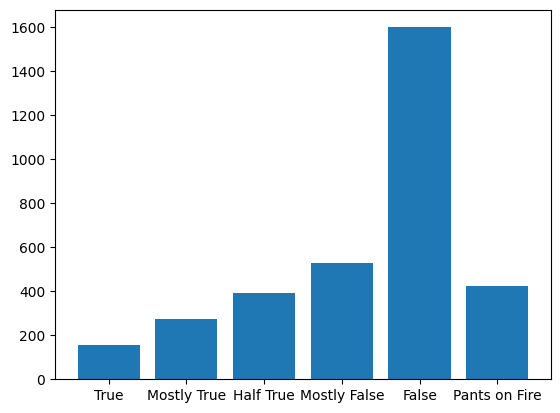

In [13]:
print(overall_distribution)
print("Total claims:", sum(overall_distribution.values()))

# Plot the overall distribution
plt.bar(overall_distribution.keys(), overall_distribution.values())
plt.show()